In [1]:
import os
import sys
import random
import math
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import matplotlib
import matplotlib.pyplot as plt

#import coco
from config import Config
import utils
import model as modellib
import visualize

import torch

In [2]:
ROOT_DIR = os.getcwd()
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_val/'

In [60]:
class CellConfig(Config):
    """Configuration for training on data science bowl 2018 dataset.
    Derives from the base Config class and overrides values specific
    to the nuclei images dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cell"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 670

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CellConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGENET_MODEL_PATH            /media/lzm/DC9458A6945884C4/projects/DSB-2018/pytorch-mask-rcnn-master/resnet50_imagenet.pth
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cell
NUM_CLASSES         

In [74]:
class CellDataset(utils.Dataset):
    def load_cells(self, mode):
        if mode == 'train':
            image_dir = os.path.join(TRAIN_PATH)
        elif mode == 'test':
            image_dir = os.path.join(TEST_PATH)
        image_list = sorted(os.listdir(image_dir))
        
        self.add_class("cells", 1, "cell")
        
        for n, id_ in enumerate(image_list):
            self.add_image(
                "cells",
                image_id=n,
                image_name=id_,
                path=image_dir+'/'+id_+'/images/',
                gt_path=image_dir+'/'+id_+'/masks/'
                )
            
    def load_mask(self, image_id, IMG_HEIGHT=256, IMG_WIDTH=256):
        image_info = self.image_info[image_id]
        #mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        mask = []
        for mask_file in next(os.walk(image_info['gt_path']))[2]:
            mask_ = np.array(imread(image_info['gt_path']+mask_file), dtype=np.bool)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                        preserve_range=True), axis=-1)
            mask.append(mask_)
        #print(mask[0])
        class_ids = np.ones([len(mask)]).astype(np.int32)
        mask = np.stack(mask,axis=2)
        mask = mask.reshape(mask.shape[0],mask.shape[1],mask.shape[2])
        return mask, class_ids
        
    def load_image(self, image_id, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
        image_info = self.image_info[image_id]
        image = imread(image_info['path'] + image_info['image_name'] + '.png')[:,:,:IMG_CHANNELS]
        image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        return image
    

In [75]:
dataset_train = CellDataset()
dataset_train.load_cells('train')
dataset_train.prepare()
dataset_val = CellDataset()
dataset_val.load_cells('test')
dataset_val.prepare()

(256, 256, 27)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


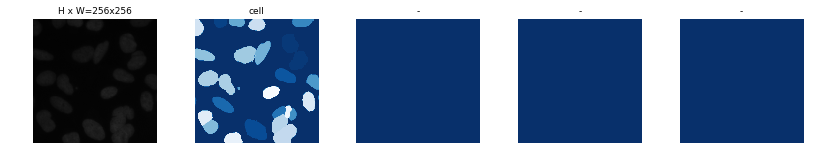

In [79]:
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    print(class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [53]:
model = modellib.MaskRCNN(config=config,
                                  model_dir='model/')
if config.GPU_COUNT:
        model = model.cuda()

#model_path = ""

#model.load_weights(model_path)

model.train_model(dataset_train, dataset_val,
                    learning_rate=config.LEARNING_RATE,
                    epochs=40,
                    layers='all')

Weight file not found ...

Starting at epoch 1. LR=0.001

Checkpoint Path: model/cell20180307T0042/mask_rcnn_cell_{:04d}.pth
Epoch 1/40.
	1/800 |----------| 0.1% Complete - loss: 143534000.00000 - rpn_class_loss: 53933412.00000 - rpn_bbox_loss: 89600584.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	2/800 |----------| 0.2% Complete - loss: 156510352.00000 - rpn_class_loss: 61901028.00000 - rpn_bbox_loss: 94609328.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	3/800 |----------| 0.4% Complete - loss: 162947616.00000 - rpn_class_loss: 62481908.00000 - rpn_bbox_loss: 100465704.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	4/800 |----------| 0.5% Complete - loss: 142048528.00000 - rpn_class_loss: 47838828.00000 - rpn_bbox_loss: 94209696.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	5/800 |----------| 0.6% Complete - loss: 

	42/800 |----------| 5.2% Complete - loss: 29719548.00000 - rpn_class_loss: 6364858.00000 - rpn_bbox_loss: 23354690.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	43/800 |----------| 5.4% Complete - loss: 32048372.00000 - rpn_class_loss: 5645929.00000 - rpn_bbox_loss: 26402444.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	44/800 |----------| 5.5% Complete - loss: 29338034.00000 - rpn_class_loss: 2920308.50000 - rpn_bbox_loss: 26417726.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	45/800 |----------| 5.6% Complete - loss: 27710612.00000 - rpn_class_loss: 2182820.50000 - rpn_bbox_loss: 25527792.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	46/800 |----------| 5.8% Complete - loss: 17121940.00000 - rpn_class_loss: 1663659.87500 - rpn_bbox_loss: 15458281.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn

	85/800 |█---------| 10.6% Complete - loss: 5204070.00000 - rpn_class_loss: 1686904.12500 - rpn_bbox_loss: 3517166.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	86/800 |█---------| 10.8% Complete - loss: 4762288.00000 - rpn_class_loss: 1234103.00000 - rpn_bbox_loss: 3528185.00000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	87/800 |█---------| 10.9% Complete - loss: 4036375.25000 - rpn_class_loss: 423079.68750 - rpn_bbox_loss: 3613295.50000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	88/800 |█---------| 11.0% Complete - loss: 4362869.50000 - rpn_class_loss: 564068.81250 - rpn_bbox_loss: 3798800.75000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_loss: 0.00000
	89/800 |█---------| 11.1% Complete - loss: 3755411.75000 - rpn_class_loss: 927862.25000 - rpn_bbox_loss: 2827549.50000 - mrcnn_class_loss: 0.00000 - mrcnn_bbox_loss: 0.00000 - mrcnn_mask_lo

Exception: Traceback (most recent call last):
  File "/home/lzm/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/lzm/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 55, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/media/lzm/DC9458A6945884C4/projects/DSB-2018/pytorch-mask-rcnn-master/model.py", line 1359, in __getitem__
    use_mini_mask=self.config.USE_MINI_MASK)
  File "/media/lzm/DC9458A6945884C4/projects/DSB-2018/pytorch-mask-rcnn-master/model.py", line 1191, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/media/lzm/DC9458A6945884C4/projects/DSB-2018/pytorch-mask-rcnn-master/utils.py", line 348, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Exception: Invalid bounding box with area of zero


In [54]:
class InferenceConfig(CellConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

NameError: name 'MODEL_DIR' is not defined

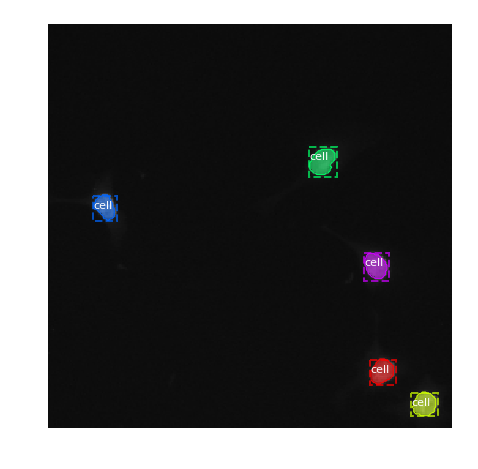

In [90]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

#log("original_image", original_image)
#log("image_meta", image_meta)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(8, 8))